In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful


# Tutorial: A LLM Implementation in PyTorch

In this tutorial, we'll walk through the basics of PyTorch and guide you through implementing a simple large language model. We'll also train the LLM on a small machine translation dataset to demonstrate the general workflow of deploying a ML model in PyTorch.

Specifically, we'll cover the following topics:

* PyTorch Basics: Familiarity with tensors, nn.Module, etc.

* The Transformer Architecture: position encoding, multi-head attention, encoder/decoder.

* Machine Translation (Seq2Seq) Example:
  * Data preparation
  * Training loops
  * Evaluation


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.nn.utils.rnn import pad_sequence
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#For Jupyter Notebook inline plotting

## What is PyTorch

PyTorch is an open-source machine learning library originally developed by Facebook's AI Research lab. It is one of the most common libraries used for building and training deep learning models.



---


## Tensors
Tensors are the backbone of PyTorch. Think of them as multi-dimensional arrays, similar to NumPy arrays but optimized for GPU acceleration.

In [ ]:
# Creating a tensor from a list
tensor_a = torch.tensor([1, 2, 3, 4, 5])
print("Tensor A:", tensor_a)

# Creating a 2D tensor (matrix)
tensor_b = torch.tensor([[1, 2], [3, 4], [5, 6]])
print("Tensor B:\n", tensor_b)

# Tensor operations
tensor_c = tensor_a + 10
print("Tensor C (A + 10):", tensor_c)

# Matrix multiplication
tensor_d = torch.matmul(tensor_b, torch.tensor([[2], [3]]))
print("Tensor D (B * [[2], [3]]):\n", tensor_d)


Tensor A: tensor([1, 2, 3, 4, 5])
Tensor B:
 tensor([[1, 2],
        [3, 4],
        [5, 6]])
Tensor C (A + 10): tensor([11, 12, 13, 14, 15])
Tensor D (B * [[2], [3]]):
 tensor([[ 8],
        [18],
        [28]])




---

## Modules

Modules in PyTorch are building blocks for neural networks. They can represent layers, activation functions, or even entire models.

In [ ]:
# Define a simple neural network module consisting of two fully connected layers with ReLU activation.
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()                              # Activation function
        self.linear2 = nn.Linear(hidden_size, output_size) # Hidden to output layer

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

# Instantiate the model
model = SimpleNN(input_size=5, hidden_size=3, output_size=2)
print(model)

SimpleNN(
  (linear1): Linear(in_features=5, out_features=3, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=3, out_features=2, bias=True)
)




---



## CUDA (GPU Support)

PyTorch can utilize NVIDIA GPUs (and new Apple M series) to speed up computations. Let's check if CUDA (PyTorch's interface for GPU) is available and move a tensor to the GPU if possible. In Google Colab, you have a set amount of GPU hours for free.

In [ ]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA Available: {cuda_available}")

# Create a tensor and move it to GPU if available
tensor = torch.tensor([1.0, 2.0, 3.0])
if cuda_available:
    tensor = tensor.to(device)
    print("Tensor moved to GPU.")
else:
    print("Tensor remains on CPU.")

print(tensor)

CUDA Available: True
Tensor moved to GPU.
tensor([1., 2., 3.], device='cuda:0')


# The Transformer Architecture

* Positiional Encoding
* Multi-Head Attention (MHA)
* Feed Forward Network (FFN)
* Encoder
* Decoder
* Transformer Network



---


## Positional Encoding

Question: Why do we need positional encoding?

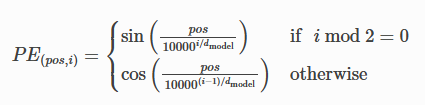

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): The dimensionality of the model's embeddings.
            max_len (int): The maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()

        # Initialize a matrix of shape (max_len, d_model) with zeros
        pe = torch.zeros(max_len, d_model)
        # Create a vector of positions (0, 1, 2, ..., max_len-1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Compute the div_term based on the formula from the paper
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
         (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd dimensions

        # Add a batch dimension
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        # Register pe as a buffer so it's not considered a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Adds positional encoding to input tensor x.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            Tensor: Tensor with positional encodings added.
        """
        # Add positional encoding to input embeddings
        x = x + self.pe[:, :x.size(1), :]
        return x

In [ ]:
# Parameters
batch_size = 1      # Number of sequences in a batch
seq_len = 10        # Number of tokens in a sequence
d_model = 16        # Embedding dimension

# Create a sample batch of token embeddings (random values)
# Shape: (batch_size, seq_len, d_model)
sample_embeddings = torch.randn(batch_size, seq_len, d_model)

print("Sample Token Embeddings:")
print(sample_embeddings.shape)
print(sample_embeddings)

Sample Token Embeddings:
torch.Size([1, 10, 16])
tensor([[[-0.5576, -0.9063, -1.6841,  1.2533,  2.3832,  0.6340,  1.1293,
           1.1656,  0.2019, -0.1867, -2.5624, -2.5129,  0.6147,  0.9397,
          -1.3010, -0.2862],
         [-0.0994,  1.0214, -1.1452, -0.1554, -0.0672, -1.3322,  1.3199,
           0.2743, -0.5159,  0.7274, -0.8523,  0.7331,  1.1748,  2.0495,
          -0.5174,  1.7581],
         [-0.2272,  1.6276,  0.4431,  1.4765, -0.9395, -0.0579, -0.6380,
          -1.1914,  1.2775, -0.2480, -1.7642,  0.3541, -0.5792,  0.9262,
          -0.6661,  1.1158],
         [ 0.8888,  0.3955,  1.2488,  0.4737, -0.1698, -1.5128, -2.1429,
           0.2027, -0.0857, -0.7850, -0.2385,  0.0731,  0.4802,  0.7578,
           1.4378, -0.3084],
         [-0.4251,  0.3728,  0.3565,  0.0816, -0.6302,  0.6844, -1.2619,
          -1.9197,  0.5627, -0.6454, -0.9183,  0.2998,  1.2813,  0.2280,
          -0.3872, -0.5139],
         [ 0.4239, -0.9155, -0.5410,  0.6207, -0.6882,  0.4554,  0.3244,
   

In [ ]:
# Instantiate the PositionalEncoding module
pos_encoder = PositionalEncoding(d_model=d_model, max_len=100)

# Apply positional encoding
encoded_embeddings = pos_encoder(sample_embeddings)

print("\nEncoded Embeddings with Positional Encoding:")
print(encoded_embeddings.shape)
print(encoded_embeddings)


Encoded Embeddings with Positional Encoding:
torch.Size([1, 10, 16])
tensor([[[-0.5576,  0.0937, -1.6841,  2.2533,  2.3832,  1.6340,  1.1293,
           2.1656,  0.2019,  0.8133, -2.5624, -1.5129,  0.6147,  1.9397,
          -1.3010,  0.7138],
         [ 0.7421,  1.5617, -0.8343,  0.7950,  0.0326, -0.3372,  1.3515,
           1.2738, -0.5059,  1.7274, -0.8491,  1.7331,  1.1758,  3.0495,
          -0.5171,  2.7581],
         [ 0.6821,  1.2114,  1.0342,  2.2831, -0.7408,  0.9221, -0.5748,
          -0.1934,  1.2975,  0.7518, -1.7579,  1.3541, -0.5772,  1.9262,
          -0.6654,  2.1158],
         [ 1.0300, -0.5945,  2.0615,  1.0565,  0.1257, -0.5574, -2.0482,
           1.1982, -0.0557,  0.2146, -0.2290,  1.0731,  0.4832,  1.7578,
           1.4387,  0.6916],
         [-1.1819, -0.2808,  1.3101,  0.3827, -0.2408,  1.6054, -1.1357,
          -0.9277,  0.6027,  0.3538, -0.9056,  1.2997,  1.2853,  1.2280,
          -0.3859,  0.4861],
         [-0.5350, -0.6318,  0.4589,  0.6103, -0.2088, 

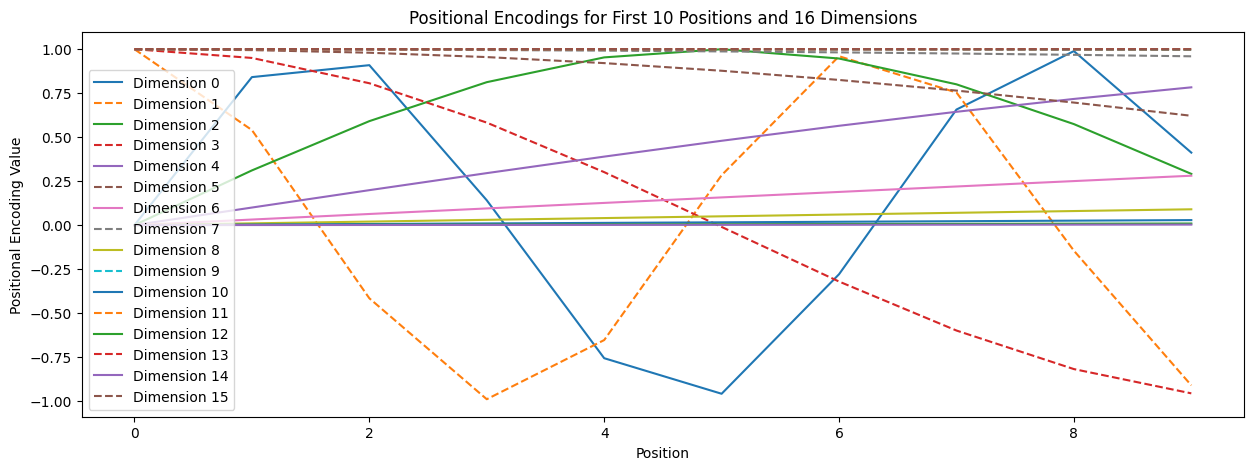

In [ ]:
# Number of positions to visualize
positions_to_plot = 10  # Plot first 10 positions

# Create a tensor to hold positional encodings
pos_encodings = pos_encoder.pe[0, :positions_to_plot, :].detach().cpu().numpy()

# Plot the positional encodings for the first few dimensions
plt.figure(figsize=(15, 5))
for i in range(0, d_model, 2):  # Plot even and odd dimensions separately
    plt.plot(range(positions_to_plot), pos_encodings[:, i], label=f'Dimension {i}')
    plt.plot(range(positions_to_plot), pos_encodings[:, i+1], linestyle='dashed', label=f'Dimension {i+1}')

plt.title('Positional Encodings for First 10 Positions and 16 Dimensions')
plt.xlabel('Position')
plt.ylabel('Positional Encoding Value')
plt.legend()
plt.show()

There can be other methods to include information regarding positions within the sequence (learned embedding vector, relative position encoding, etc)



---



## Multi-Head Attention

Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, capturing various relationships and features.

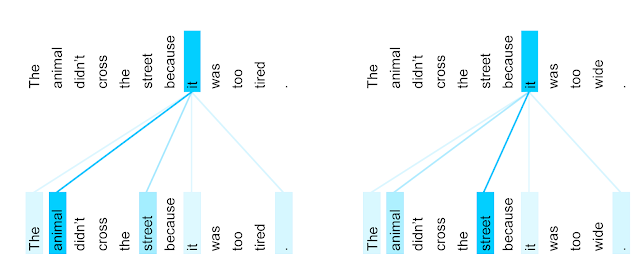

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Initializes the Multi-Head Attention module.

        Args:
            d_model (int): The dimensionality of the model's embeddings.
            num_heads (int): The number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()

        # Ensure that d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model  # Dimensionality of the model
        self.num_heads = num_heads  # Number of attention heads
        self.d_k = d_model // num_heads  # Dimensionality per head

        # Define linear layers to project inputs to queries, keys, and values
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Softmax layer to compute attention weights
        self.softmax = nn.Softmax(dim=-1)

        # Output linear layer after concatenating all heads
        self.out = nn.Linear(d_model, d_model)


    def forward(self, query, key, value, mask=None):
        """
        Performs multi-head attention.

        Args:
            query (Tensor): Query tensor of shape (batch_size, seq_len, d_model).
            key (Tensor): Key tensor of shape (batch_size, seq_len, d_model).
            value (Tensor): Value tensor of shape (batch_size, seq_len, d_model).
            mask (Tensor, optional): Mask tensor to prevent attention to certain positions.
                                      Shape: (batch_size, 1, 1, seq_len) or None.

        Returns:
            Tensor: Output tensor after applying multi-head attention.
                    Shape: (batch_size, seq_len, d_model).
        """
        batch_size = query.size(0)  # Get the batch size

        # Step 1: Linear projections
        # Project queries, keys, and values using the respective linear layers
        # Each has shape: (batch_size, seq_len, d_model)
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Step 2: Reshape and split into multiple heads
        # After view: (batch_size, seq_len, num_heads, d_k)
        # After transpose: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Step 3: Scaled Dot-Product Attention
        # Compute attention scores by matrix multiplication of Q and K^T
        # scores shape: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Step 4: Apply mask (if provided) to the attention scores
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)  # Assign a large negative value to masked positions

        # Step 5: Compute attention weights using softmax
        attn = self.softmax(scores)  # Shape: (batch_size, num_heads, seq_len, seq_len)

        # Step 6: Compute the attention output by weighting the values with attention weights
        context = torch.matmul(attn, V)  # Shape: (batch_size, num_heads, seq_len, d_k)

        # Step 7: Concatenate all attention heads
        # First, transpose to (batch_size, seq_len, num_heads, d_k)
        # Then, reshape to (batch_size, seq_len, d_model) by merging num_heads and d_k
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Step 8: Final linear layer to project back to original d_model dimensions
        out = self.out(context)  # Shape: (batch_size, seq_len, d_model)

        return out

There can also be different types of attention mechanisms that can be used to compute attention scores (we use scaled dot product as in the original Transformer paper). For example, in your first assignment, you will see Bahdanau attention.



---

## Feed-Forward Network
A simple two-layer feed-forward network with a ReLU activation introduces non-linearity and allows the model to capture complex relationships.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=512):
        """
        Initializes the FeedForward module.

        Args:
            d_model (int): The dimensionality of the model's embeddings.
            d_ff (int): The dimensionality of the feed-forward layer.
        """
        super(FeedForward, self).__init__()
        # Define two linear transformations with a ReLU activation in between
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Applies the feed-forward network to input tensor x.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            Tensor: Output tensor after applying the feed-forward network.
        """
        out = self.linear1(x)  # First linear transformation
        out = self.relu(out)    # ReLU activation
        out = self.linear2(out) # Second linear transformation
        return out




---


## Encoder and Decoder Layers
Each Encoder layer consists of multi-head attention followed by a feed-forward network. Similarly, each Decoder layer includes masked multi-head attention, encoder-decoder attention, and a feed-forward network.

Question: Why does the decoder use masked multi-head attention?

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Initializes the EncoderLayer module.

        Args:
            d_model (int): The dimensionality of the model's embeddings.
            num_heads (int): The number of attention heads.
        """
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)  # Self-attention mechanism
        self.feed_forward = FeedForward(d_model)                 # Feed-forward network
        # There can be different types of normalizations methods
        self.norm1 = nn.LayerNorm(d_model)                       # Layer normalization after attention
        self.norm2 = nn.LayerNorm(d_model)                       # Layer normalization after feed-forward

    def forward(self, src, mask):
        """
        Passes the input through the encoder layer.

        Args:
            src (Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            mask (Tensor): Mask tensor to prevent attention to certain positions.

        Returns:
            Tensor: Output tensor after processing through the encoder layer.
        """
        # Self-attention sublayer
        attn_output = self.attention(src, src, src, mask)
        # Add & Normalize (can be the other way)
        src = self.norm1(src + attn_output)

        # Feed-forward sublayer
        ff_output = self.feed_forward(src)
        # Add & Normalize
        src = self.norm2(src + ff_output)

        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Initializes the DecoderLayer module.

        Args:
            d_model (int): The dimensionality of the model's embeddings.
            num_heads (int): The number of attention heads.
        """
        super(DecoderLayer, self).__init__()
        self.attention1 = MultiHeadAttention(d_model, num_heads)  # Masked self-attention
        self.attention2 = MultiHeadAttention(d_model, num_heads)  # Encoder-decoder attention
        self.feed_forward = FeedForward(d_model)                 # Feed-forward network
        self.norm1 = nn.LayerNorm(d_model)                       # Layer normalization after first attention
        self.norm2 = nn.LayerNorm(d_model)                       # Layer normalization after second attention
        self.norm3 = nn.LayerNorm(d_model)                       # Layer normalization after feed-forward

    def forward(self, tgt, enc_output, tgt_mask, src_mask):
        """
        Passes the input through the decoder layer.

        Args:
            tgt (Tensor): Target tensor of shape (batch_size, tgt_len, d_model).
            enc_output (Tensor): Encoder output tensor of shape (batch_size, src_len, d_model).
            tgt_mask (Tensor): Mask tensor for the target to prevent attention to future tokens.
            src_mask (Tensor): Mask tensor for the source to prevent attention to padding tokens.

        Returns:
            Tensor: Output tensor after processing through the decoder layer.
        """
        # Masked self-attention sublayer
        attn1_output = self.attention1(tgt, tgt, tgt, tgt_mask)
        # Add & Normalize
        tgt = self.norm1(tgt + attn1_output)

        # Encoder-decoder attention sublayer
        attn2_output = self.attention2(tgt, enc_output, enc_output, src_mask)
        # Add & Normalize
        tgt = self.norm2(tgt + attn2_output)

        # Feed-forward sublayer
        ff_output = self.feed_forward(tgt)
        # Add & Normalize
        tgt = self.norm3(tgt + ff_output)

        return tgt




---


## The Full Transformer Model
Combining the encoder and decoder layers, along with embedding layers and positional encoding, we build the complete Transformer architecture.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, num_layers=2, num_heads=8, d_ff=512, max_len=100):
        """
        Initializes the Transformer model.

        Args:
            src_vocab_size (int): Size of the source vocabulary.
            tgt_vocab_size (int): Size of the target vocabulary.
            d_model (int): Dimensionality of the model's embeddings.
            num_layers (int): Number of encoder and decoder layers.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimensionality of the feed-forward network.
            max_len (int): Maximum length of input sequences.
        """
        super(Transformer, self).__init__()

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Stacking encoder and decoder layers
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads) for _ in range(num_layers)])

        # Final linear layer to generate output probabilities
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def make_src_mask(self, src):
        """
        Creates a mask for the source sequences to ignore padding tokens.

        Args:
            src (Tensor): Source tensor of shape (batch_size, src_len).

        Returns:
            Tensor: Source mask of shape (batch_size, 1, 1, src_len).
        """
        # Mask positions where src is not PAD_TOKEN = 0
        mask = (src != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, src_len)
        return mask.to(device)

    def make_tgt_mask(self, tgt):
        """
        Creates a mask for the target sequences to ignore padding tokens and future tokens.

        Args:
            tgt (Tensor): Target tensor of shape (batch_size, tgt_len).

        Returns:
            Tensor: Target mask of shape (batch_size, 1, tgt_len, tgt_len).
        """
        # Mask positions where tgt is not PAD_TOKEN = 0
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, tgt_len)
        tgt_len = tgt.size(1)
        # Mask future positions to prevent attention to them
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
        # Combine masks
        tgt_mask = tgt_pad_mask & tgt_sub_mask  # Shape: (batch_size, 1, tgt_len, tgt_len)
        return tgt_mask

    def forward(self, src, tgt):
        """
        Forward pass through the Transformer model.

        Args:
            src (Tensor): Source tensor of shape (batch_size, src_len).
            tgt (Tensor): Target tensor of shape (batch_size, tgt_len).

        Returns:
            Tensor: Output tensor of shape (batch_size, tgt_len, tgt_vocab_size).
        """
        # Create masks
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        # Embed and add positional encoding
        enc_src = self.positional_encoding(self.src_embedding(src))  # Shape: (batch_size, src_len, d_model)
        dec_tgt = self.positional_encoding(self.tgt_embedding(tgt))  # Shape: (batch_size, tgt_len, d_model)

        # Pass through encoder layers
        for layer in self.encoder_layers:
            enc_src = layer(enc_src, src_mask)

        # Pass through decoder layers
        for layer in self.decoder_layers:
            dec_tgt = layer(dec_tgt, enc_src, tgt_mask, src_mask)

        # Generate output probabilities
        out = self.fc_out(dec_tgt)  # Shape: (batch_size, tgt_len, tgt_vocab_size)

        # Where's softmax?

        return out

# Example: Machine Translation (Seq2Seq)

Now we will run a small-scale experiment for the Transformer we've just built on a Eng/Fr translation dataset (also used in your first assignment).

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract to Google Drive to follow along.

*Dataset from: [Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
by Sean Robertson*


```sh
[KEY: > Eng, = Fr]

> il est en train de peindre un tableau .
= he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
```

We'll go over a simple ML pipeline in PyTorch:

* Data Preparation
* Training Loop
* Evaluation



---


## Data Preparation

Before training our Transformer model, it's essential to convert raw text into a numerical format that the model can process. To do so, we will need:

* Tokenizer: Splits sentences into lowercase words based on spaces.
* Vocabulary: Constructs separate vocabularies for source (English) and target (French) languages, mapping words to unique indices.
* Dataset and DataLoader (from PyTorch): Prepares and stores the data for training by padding sequences and organizing them into batches.


In [ ]:
import os
import random
from torch.utils.data import DataLoader, Dataset

# Path to your eng-fra.txt file
DATA_PATH = '/content/drive/MyDrive/data/eng-fra.txt'

# Check if the file exists
if not os.path.isfile(DATA_PATH):
    raise FileNotFoundError(f"The data file {DATA_PATH} does not exist.")

# Read the data file and filter sentences starting with "i am" (case-insensitive)
all_data = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            parts = line.split('\t')
            if len(parts) != 2:
                continue  # Skip malformed lines
            src, tgt = parts
            if src.lower().startswith("i am"):
                all_data.append((src, tgt))

print(f"Total 'I am' sentence pairs: {len(all_data)}")

# Limit to max_samples
max_samples = 800
if len(all_data) > max_samples:
    data = random.sample(all_data, max_samples)
    print(f"Selected {max_samples} 'I am' sentence pairs for training/testing.")
else:
    data = all_data
    print(f"Using all available {len(data)} 'I am' sentence pairs.")

# Special tokens
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
PAD_TOKEN = '<pad>'

# Simple tokenizer: split by spaces
def tokenize(sentence):
    """
    Tokenizes a sentence by splitting on spaces.

    Args:
        sentence (str): The sentence to tokenize.

    Returns:
        list: List of tokenized words.
    """
    return sentence.lower().split()

# Vocabulary class
class Vocab:
    def __init__(self):
        """
        Initializes the vocabulary with special tokens.
        """
        self.word2idx = {PAD_TOKEN:0, SOS_TOKEN:1, EOS_TOKEN:2}
        self.idx2word = {0:PAD_TOKEN, 1:SOS_TOKEN, 2:EOS_TOKEN}
        self.count = 3  # Start indexing from 3

    def add_sentence(self, sentence):
        """
        Adds words from a sentence to the vocabulary.

        Args:
            sentence (str): The sentence to add.
        """
        for word in tokenize(sentence):
            if word not in self.word2idx:
                self.word2idx[word] = self.count
                self.idx2word[self.count] = word
                self.count +=1

    def numericalize(self, sentence):
        """
        Converts a sentence into a list of numerical indices.

        Args:
            sentence (str): The sentence to numericalize.

        Returns:
            list: List of indices representing the sentence.
        """
        return [self.word2idx[SOS_TOKEN]] + [self.word2idx.get(word, self.word2idx[PAD_TOKEN]) for word in tokenize(sentence)] + [self.word2idx[EOS_TOKEN]]

    def __len__(self):
        """
        Returns the size of the vocabulary.

        Returns:
            int: Vocabulary size.
        """
        return len(self.word2idx)

# Create source and target vocabularies
src_vocab = Vocab()
tgt_vocab = Vocab()

for src, tgt in data:
    src_vocab.add_sentence(src)
    tgt_vocab.add_sentence(tgt)

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)

print(f"Source Vocabulary Size: {SRC_VOCAB_SIZE}")
print(f"Target Vocabulary Size: {TGT_VOCAB_SIZE}")


# Custom Dataset class
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab):
        """
        Initializes the dataset.

        Args:
            data (list of tuples): List of (source_sentence, target_sentence) tuples.
            src_vocab (Vocab): Source language vocabulary.
            tgt_vocab (Vocab): Target language vocabulary.
        """
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (source_sequence, target_sequence)
        """
        src, tgt = self.data[idx]
        src_seq = torch.tensor(self.src_vocab.numericalize(src), dtype=torch.long)
        tgt_seq = torch.tensor(self.tgt_vocab.numericalize(tgt), dtype=torch.long)
        return src_seq, tgt_seq

# Collate function to pad sequences within a batch
def collate_fn(batch):
    """
    Pads sequences in a batch to the same length.

    Args:
        batch (list of tuples): List of (source_sequence, target_sequence) tuples.

    Returns:
        tuple: Padded source and target tensors.
    """
    src_batch, tgt_batch = zip(*batch)
    src_padded = pad_sequence(src_batch, padding_value=src_vocab.word2idx[PAD_TOKEN], batch_first=True)
    tgt_padded = pad_sequence(tgt_batch, padding_value=tgt_vocab.word2idx[PAD_TOKEN], batch_first=True)
    return src_padded.to(device), tgt_padded.to(device)

Total 'I am' sentence pairs: 807
Selected 800 'I am' sentence pairs for training/testing.
Source Vocabulary Size: 938
Target Vocabulary Size: 1152


To prepare our data, we'll use the DataLoader/Dataset provided by PyTorch.

Typically, we will split our data into train/val/test splits where val is used for hyperparameter tuning. However, since we won't be doing any of that in the tutorial, the data is only split into train/test.

In [ ]:
# Create Dataset and DataLoader
dataset = TranslationDataset(data, src_vocab, tgt_vocab)

# Split into training and testing (80-20 split)
split_ratio = 0.8
split_idx = int(len(dataset) * split_ratio)
train_data = dataset.data[:split_idx]
test_data = dataset.data[split_idx:]

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Create DataLoaders
BATCH_SIZE = 3  # Adjust based on dataset size and available memory

train_dataset = TranslationDataset(train_data, src_vocab, tgt_vocab)
test_dataset = TranslationDataset(test_data, src_vocab, tgt_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


# Demonstration: Loading a batch from train_loader and showing padding
print("\n--- Demonstration ---")

# Fetch the first batch from train_loader
src_batch, tgt_batch = next(iter(train_loader))  # Get the first batch


print("\nEnglish (Decoded):")
for src_seq in src_batch:
    words = [src_vocab.idx2word[idx.item()] for idx in src_seq]
    print(words)

print("\nFrench (Decoded):")
for tgt_seq in tgt_batch:
    words = [tgt_vocab.idx2word[idx.item()] for idx in tgt_seq]
    print(words)

print("\nEnglish (Numericalized):")
print(src_batch)

print("\nFrench (Numericalized):")
print(tgt_batch)

Training samples: 640
Testing samples: 160

--- Demonstration ---

English (Decoded):
['<sos>', 'i', 'am', 'very', 'sensitive', 'to', 'the', 'cold.', '<eos>']
['<sos>', 'i', 'am', 'too', 'tired', 'to', 'run.', '<eos>', '<pad>']
['<sos>', 'i', 'am', 'eating', 'a', 'sandwich.', '<eos>', '<pad>', '<pad>']

French (Decoded):
['<sos>', 'je', 'suis', 'très', 'sensible', 'au', 'froid.', '<eos>', '<pad>', '<pad>']
['<sos>', 'je', 'suis', 'trop', 'fatigué', 'pour', 'courir.', '<eos>', '<pad>', '<pad>']
['<sos>', 'je', 'suis', 'en', 'train', 'de', 'manger', 'un', 'sandwich.', '<eos>']

English (Numericalized):
tensor([[  1,   3,   4,  71, 500,   6,   8, 225,   2],
        [  1,   3,   4, 352,  33,   6, 416,   2,   0],
        [  1,   3,   4,  35,  53, 425,   2,   0,   0]], device='cuda:0')

French (Numericalized):
tensor([[  1,   3,   9,  82, 591, 234, 250,   2,   0,   0],
        [  1,   3,   9, 407,  45, 138, 487,   2,   0,   0],
        [  1,   3,   9,  10,  11,  17,  40,  61, 498,   2]], dev



---


## Training the Transformer Model

With the data ready and the model defined, it's time to train our Transformer. We'll set up the training loop, define the loss function, and choose an optimizer.

In [ ]:
# Create DataLoaders
BATCH_SIZE = 10  # Adjust based on dataset size and available memory

train_dataset = TranslationDataset(train_data, src_vocab, tgt_vocab)
test_dataset = TranslationDataset(test_data, src_vocab, tgt_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Hyperparameters
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
D_FF = 512
MAX_LEN = 30  # Should be >= max sequence length
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

# Initialize the Transformer model
model = Transformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    d_model=D_MODEL,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    max_len=MAX_LEN
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab.word2idx[PAD_TOKEN]) # This has built in softmax
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0

    for src, tgt in train_loader:
        optimizer.zero_grad()

        # Prepare input and target sequences
        # TEACHER FORCING
        input_src = src  # (batch_size, src_len)
        input_tgt = tgt[:, :-1]  # Remove the last token for input to decoder
        target = tgt[:, 1:].contiguous().view(-1)  # Remove the first token for target

        # Forward pass
        output = model(input_src, input_tgt)  # (batch_size, tgt_len -1, tgt_vocab_size)
        output = output.view(-1, TGT_VOCAB_SIZE)  # Reshape for loss computation

        # Compute loss
        loss = criterion(output, target)
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    # Print loss every 50 epochs and at the first epoch
    if epoch % 10 == 0 or epoch == 1:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 4.4862
Epoch 10, Loss: 0.1901
Epoch 20, Loss: 0.4519
Epoch 30, Loss: 0.1242
Epoch 40, Loss: 0.0976
Epoch 50, Loss: 0.0929
Epoch 60, Loss: 0.0846
Epoch 70, Loss: 0.2093
Epoch 80, Loss: 0.0964
Epoch 90, Loss: 0.0885
Epoch 100, Loss: 0.3835


Teacher forcing

Imagine you have a target sentence: sos I am happy eos

* Decoder Input (input_tgt): sos I am happy

* Target Output (target): I am happy eos




---


## Evaluation
Now we can define a function to translate a given source sentence using the trained model. And then apply it to some of our data (greedy decoding). For now, we will just use the eye test to evaluate the model. In the assignment, you will be using metrics such BLEU score for evaluation.

In [ ]:
# Cell 11: Evaluation Function
def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_len=100):
    """
    Translate a given sentence using the trained Transformer model.

    Args:
        model (nn.Module): Trained Transformer model.
        sentence (str): Source sentence to translate.
        src_vocab (Vocab): Source language vocabulary.
        tgt_vocab (Vocab): Target language vocabulary.
        max_len (int): Maximum length of the translated sentence.

    Returns:
        str: Translated sentence.
    """
    model.eval()

    # Tokenize and numericalize the source sentence
    tokens = tokenize(sentence)
    numericalized = [src_vocab.word2idx.get(token, 0) for token in tokens]
    numericalized = [src_vocab.word2idx[SOS_TOKEN]] + numericalized + [src_vocab.word2idx[EOS_TOKEN]]
    src_tensor = torch.tensor(numericalized, dtype=torch.long).unsqueeze(0).to(device)  # (1, src_len)

    with torch.no_grad():
        enc_output = model.positional_encoding(model.src_embedding(src_tensor))
        enc_output = enc_output  # (1, src_len, d_model)

        # Pass through encoder layers
        for layer in model.encoder_layers:
            enc_output = layer(enc_output, model.make_src_mask(src_tensor))

        # Initialize target sequence with <sos>
        tgt_indices = [tgt_vocab.word2idx[SOS_TOKEN]]

        for _ in range(max_len):
            tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)  # (1, tgt_len)
            dec_tgt = model.positional_encoding(model.tgt_embedding(tgt_tensor))

            # Pass through decoder layers
            for layer in model.decoder_layers:
                dec_tgt = layer(dec_tgt, enc_output, model.make_tgt_mask(tgt_tensor), model.make_src_mask(src_tensor))

            # Generate output probabilities
            output = model.fc_out(dec_tgt)  # (1, tgt_len, tgt_vocab_size)
            output = output[:, -1, :]  # Get the last time step

            # Choose the word with the highest probability
            _, next_word = torch.max(output, dim=1)
            next_word = next_word.item()

            # Append to the target sequence
            tgt_indices.append(next_word)

            # Stop if <eos> is generated
            if next_word == tgt_vocab.word2idx[EOS_TOKEN]:
                break

    # Convert indices back to words, excluding <sos> and <eos>
    translated_tokens = [tgt_vocab.idx2word[idx] for idx in tgt_indices[1:-1]]
    return ' '.join(translated_tokens)


# Function to evaluate and display translations
def evaluate_model(model, dataset, src_vocab, tgt_vocab, num_examples=5, dataset_name="Dataset"):
    """
    Evaluate the model on a given dataset and print sample translations.

    Args:
        model (nn.Module): Trained Transformer model.
        dataset (list of tuples): List of (source_sentence, target_sentence).
        src_vocab (Vocab): Source language vocabulary.
        tgt_vocab (Vocab): Target language vocabulary.
        num_examples (int): Number of examples to display.
        dataset_name (str): Name of the dataset (e.g., "Training", "Test").
    """
    print(f"\n--- {dataset_name} Evaluation ---")
    samples = random.sample(dataset, min(num_examples, len(dataset)))

    for idx, (src, tgt) in enumerate(samples, 1):
        translation = translate_sentence(model, src, src_vocab, tgt_vocab)
        print(f"Example {idx}:")
        print(f"Source: {src}")
        print(f"Predicted Translation: {translation}")
        print(f"Target Translation: {tgt}\n")



---


Let's see how the model performs.

In [ ]:
# Evaluate on Training Data
evaluate_model(model, train_data, src_vocab, tgt_vocab, num_examples=5, dataset_name="Training Data")


--- Training Data Evaluation ---
Example 1:
Source: I am a bad person.
Predicted Translation: je suis un homme qui
Target Translation: Je suis un être mauvais.

Example 2:
Source: I am cooking now.
Predicted Translation: en ce moment. je n'étudie en cuisine
Target Translation: Je cuisine en ce moment.

Example 3:
Source: I am no longer a child.
Predicted Translation: je ne suis plus un enfant.
Target Translation: Je ne suis plus un enfant.

Example 4:
Source: I am sure.
Predicted Translation: je suis sûr.
Target Translation: Je suis certain.

Example 5:
Source: I am no more an artist than you are.
Predicted Translation: je ne suis pas plus artiste que toi.
Target Translation: Je ne suis pas plus artiste que toi.



What about the test data?

In [ ]:
# Evaluate on Testing Data
evaluate_model(model, test_data, src_vocab, tgt_vocab, num_examples=5, dataset_name="Test Data")


--- Test Data Evaluation ---
Example 1:
Source: I am not alone in this opinion.
Predicted Translation: je ne suis pas en étudiant à l'université que à ce mode
Target Translation: Je ne suis pas le seul à avoir cette opinion.

Example 2:
Source: I am not a doctor, but a teacher.
Predicted Translation: je ne suis pas médecin, mais professeur.
Target Translation: Je ne suis pas médecin, mais enseignant.

Example 3:
Source: I am sad to hear it.
Predicted Translation: je me réjouis de l'entendre.
Target Translation: Ça me rend triste d'entendre ça.

Example 4:
Source: I am human.
Predicted Translation: je suis chaque train par j'ai je devoirs.
Target Translation: Je suis humain.

Example 5:
Source: I am going to do it whether you agree or not.
Predicted Translation: je vais en mesure de parler de cette vulgaire manière.
Target Translation: Je vais le faire, que tu sois d'accord ou pas.






---

## Further Reading:

[**Blog Post Explaining the Transformer (Lots of Visuals)**](https://jalammar.github.io/illustrated-transformer/)

[**Blog Post About Transformer Variants**](https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/)






---


## References

Original Transformer Paper and Visuals: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)

Code Snippets: [Tutorial 6: Transformers and Multi-Head Attention
](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

Dataset: [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)




